<a href="https://colab.research.google.com/github/ReAlex1902/Stock_Price_Prediction/blob/master/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all necessary libraries

In [ ]:
!pip install yfinance
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from datetime import date

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# The data preprocessing steps:
1) Reading data with yahoo_finance and pandas_datareader \
2) Creating subdatasets with date (day of the year, month, day of the week, hour of the day) \
3) Scale data to values from 0 and 1 (sklearn.preprocessing.MinMaxScaler()) \
4) Group data into sequences to be used as inputs and split for training and testing

In [ ]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = np.array([])
test_x = {}
test_y = {}
for_plot = {}

tickers = ['AAPL', 'AMZN', 'T', 'MA', 'V', 'MSFT', 'TSLA', 'FB']
start_date = '1990-04-01'
end_date = date.today()

for ticker in tickers:
    df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)         ## Reading data 
    df['Datetime'] = df.index
    df = df[['Close', 'Datetime']] 

    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    print(f'Ticker: {ticker}, Length: {len(df)}' )

    ## Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    ## Save the scalers to rescale data in the future
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[ticker] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data with different tickers into a single array
    test_portion = int(0.2*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
        for_plot[ticker] = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
        for_plot[ticker] = labels[:-test_portion]
    test_x[ticker] = (inputs[-test_portion:])
    test_y[ticker] = (labels[-test_portion:])

Ticker: AAPL, Length: 7682
Ticker: AMZN, Length: 5881
Ticker: T, Length: 7682
Ticker: MA, Length: 3610
Ticker: V, Length: 3154
Ticker: MSFT, Length: 7682
Ticker: TSLA, Length: 2580
Ticker: FB, Length: 2103


In [ ]:
train_x.shape, train_y.shape

((31726, 90, 5), (31726, 1))

In [ ]:
labels.shape

(2013, 1)

In [ ]:
len(for_plot['AAPL'])

6074

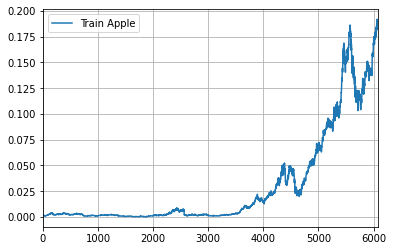

In [ ]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(for_plot['AAPL'], label = 'Train Apple')
plt.legend()
plt.show()

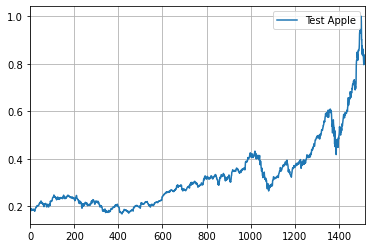

In [ ]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test_y['AAPL'], label = 'Test Apple')
plt.legend()
plt.show()

### Creating PyTorch Dataset

In [ ]:
batch_size = 256

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, drop_last = True)

In [ ]:
## Let's use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Initializing GRU (Gated Recurrent Unit) and LSTM (Long Short-Term Memory)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first = True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

To evaluate our models we will use Mean Absolute Persentage Error (MAPE)  and Symmetric Mean Absolute Persentage Error (sMAPE)

These are formulas for *MAPE* and *sMAPE*:\
$MAPE = \frac{1}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{F_t}$ \
$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$ \


${F_t} - actual\ value$ \
${A_t} - predicted\ valeu$

In [ ]:
def train_model(model, criterion, optimizer, train_loader, EPOCHS = 5):

    model.to(device)

    model.train()
    print('Starting training')
    epoch_times = []
    loss_history = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.

        for counter, (x, label) in enumerate(train_loader):
            
            try:
                h = h.data      ## hidden layer for GRU
            except:
                h = tuple([e.data for e in h])      ## hidden layer for LSTM
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            if counter % 200 == 0:
                loss_history.append(avg_loss / (counter + 1))
                print(f"Epoch {epoch}, Step: {counter}/{len(train_loader)}, Average Loss for Epoch: {avg_loss / (counter + 1)}")
        current_time = time.clock()
        print(f"Epoch {epoch}/{EPOCHS} Done, Total Loss: {avg_loss/len(train_loader)}")
        print(f"Time Elapsed for Epoch: {str(current_time-start_time)} seconds")
        print()
        epoch_times.append(current_time-start_time)

    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return loss_history

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()

    outputs = np.array([])
    targets = np.array([])
    start_time = time.clock()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)

    outputs = np.append(outputs, label_scalers.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets = np.append(targets, label_scalers.inverse_transform(labs.numpy()).reshape(-1))

    print()
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))

    sMAPE = np.mean(np.sum(np.abs(outputs-targets)/(targets+outputs)/2)/len(outputs))
    MAPE = np.mean(np.sum(np.abs(targets - outputs)/targets)/len(outputs))

    print("sMAPE: {}%".format(sMAPE*100))
    print("MAPE: {}%".format(MAPE*100))

    return outputs, targets, sMAPE, MAPE

### GRU

In [ ]:
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 1
n_layers = 2
hidden_dim = 256

gru_model = GRU(input_dim, hidden_dim, output_dim, n_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr = 0.001)

gru_model.to(device)

loss_history = train_model(gru_model, criterion, optimizer, train_loader, 10)

Starting training
Epoch 1, Step: 0/123, Average Loss for Epoch: 0.06499553471803665
Epoch 1/10 Done, Total Loss: 0.003206635007293558
Time Elapsed for Epoch: 6.1101649999999985 seconds

Epoch 2, Step: 0/123, Average Loss for Epoch: 0.00011591929069254547
Epoch 2/10 Done, Total Loss: 0.00014999945107582442
Time Elapsed for Epoch: 6.080814999999998 seconds

Epoch 3, Step: 0/123, Average Loss for Epoch: 0.0001692816731519997
Epoch 3/10 Done, Total Loss: 0.00013235589183868872
Time Elapsed for Epoch: 6.050280000000001 seconds

Epoch 4, Step: 0/123, Average Loss for Epoch: 7.338201248785481e-05
Epoch 4/10 Done, Total Loss: 0.00012477238712703612
Time Elapsed for Epoch: 6.0433270000000014 seconds

Epoch 5, Step: 0/123, Average Loss for Epoch: 0.0001006912934826687
Epoch 5/10 Done, Total Loss: 0.00012051042006540346
Time Elapsed for Epoch: 6.056429999999999 seconds

Epoch 6, Step: 0/123, Average Loss for Epoch: 0.00011782391811721027
Epoch 6/10 Done, Total Loss: 0.00011308818929085728
Time El

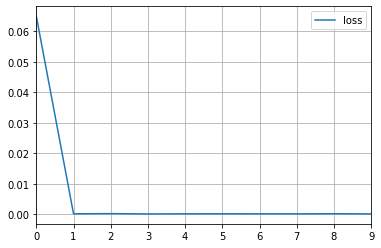

In [ ]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(loss_history, label = 'loss')
plt.legend()
plt.show()

##### Let's see the GRU results

In [ ]:
ticker = 'AAPL'
outputs, targets, sMAPE, MAPE = evaluate(gru_model, test_x[ticker], test_y[ticker], label_scalers[ticker])


Evaluation Time: 0.06188599999998701
sMAPE: 0.5755098043293615%
MAPE: 2.2793655352048225%


In [ ]:
outputs = np.array(outputs)
outputs = outputs.reshape(-1)

targets = np.array(targets)
targets = targets.reshape(-1)

outputs.shape, targets.shape

((1518,), (1518,))

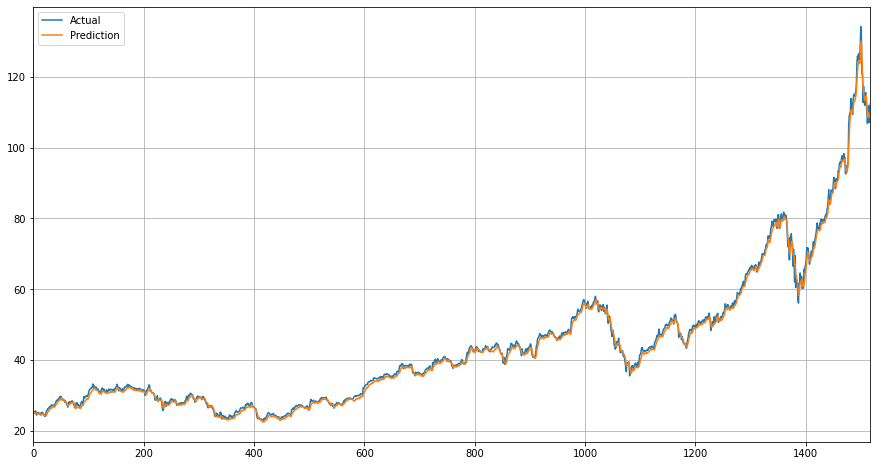

In [ ]:
plt.figure(figsize = (15, 8))

plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(targets[0:], label = 'Actual')
plt.plot(outputs[1:], label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
for i in range(len(outputs) - 1):
    if np.abs(outputs[i+1] - targets[i]) >5:
        print(outputs[i+1], targets[i], outputs[i+1] - targets[i])

99.41751098632812 106.26000213623047 -6.842491149902344
103.57305908203125 108.9375 -5.36444091796875
119.1544189453125 124.37000274658203 -5.215583801269531
128.5168914794922 134.17999267578125 -5.6631011962890625


### LSTM

In [ ]:
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 1
n_layers = 2
hidden_dim = 256

lstm_model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.001)

lstm_model.to(device)

loss_history = train_model(lstm_model, criterion, optimizer, train_loader, 10)

Starting training
Epoch 1, Step: 0/123, Average Loss for Epoch: 0.03742903470993042
Epoch 1/10 Done, Total Loss: 0.0047853070781996845
Time Elapsed for Epoch: 7.001298999999989 seconds

Epoch 2, Step: 0/123, Average Loss for Epoch: 0.0002053119969787076
Epoch 2/10 Done, Total Loss: 0.0001864518501277165
Time Elapsed for Epoch: 7.0010970000000015 seconds

Epoch 3, Step: 0/123, Average Loss for Epoch: 0.00019144127145409584
Epoch 3/10 Done, Total Loss: 0.00017204806612041682
Time Elapsed for Epoch: 7.024470000000008 seconds

Epoch 4, Step: 0/123, Average Loss for Epoch: 0.000126482336781919
Epoch 4/10 Done, Total Loss: 0.00016989967441735258
Time Elapsed for Epoch: 6.999672999999987 seconds

Epoch 5, Step: 0/123, Average Loss for Epoch: 0.0001992268953472376
Epoch 5/10 Done, Total Loss: 0.00015736863701377155
Time Elapsed for Epoch: 7.010210000000001 seconds

Epoch 6, Step: 0/123, Average Loss for Epoch: 0.00034715328365564346
Epoch 6/10 Done, Total Loss: 0.00015294977445562362
Time Elap

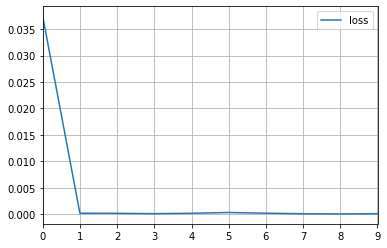

In [ ]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(loss_history, label = 'loss')
plt.legend()
plt.show()

##### Let's see the LSTM results

In [ ]:
ticker = 'AAPL'
outputs, targets, sMAPE, MAPE = evaluate(lstm_model, test_x[ticker], test_y[ticker], label_scalers[ticker])


Evaluation Time: 0.0775600000000054
sMAPE: 0.5998170582351439%
MAPE: 2.4048879860710146%


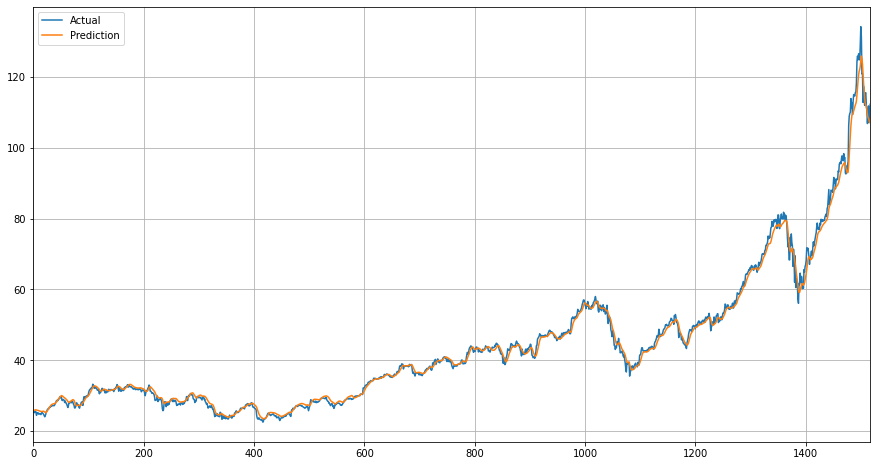

In [ ]:
plt.figure(figsize = (15, 8))

plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(targets[0:], label = 'Actual')
plt.plot(outputs[1:], label = 'Prediction')
plt.legend()
plt.show()

#### Conclusion: in terms of the metrics, GRU looks a little more accurate than LSTM. The plots show that the LSTM is smoother, while the GRU tries to predict each acute case